In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


<AxesSubplot:>

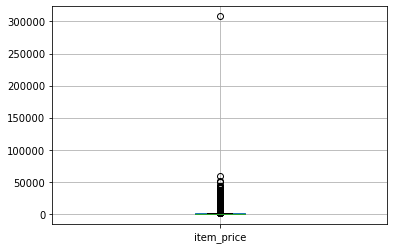

In [8]:
sales.boxplot(column=['item_price'])

In [9]:
lessthanzero = sales[sales.item_price <= 0]
lessthanzero.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
sales_train = sales[(sales.item_price > 0) & (sales.item_price < 300000)]

<AxesSubplot:>

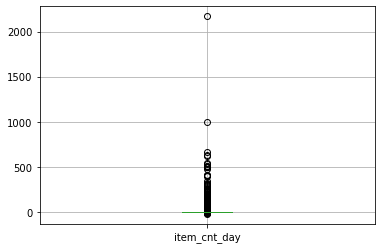

In [11]:
sales_train.boxplot(column=['item_cnt_day'])

In [12]:
sales_train = sales_train[sales_train.item_cnt_day < 750]

<AxesSubplot:>

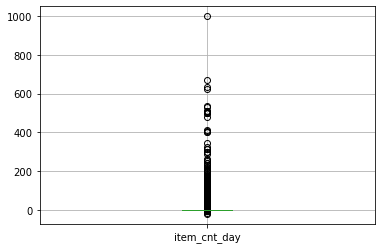

In [13]:
sales_train.boxplot(column=['item_cnt_day'])

In [14]:
## ITEMS DATA PREP

In [15]:
pd.options.display.max_rows = 1000
item_categories.head(100)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [16]:
items = pd.merge(items, item_categories, on='item_category_id')
items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [17]:
items['genre'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино


In [18]:
manual_genre_edit = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители', #Blank Media
            'PC ': 'Аксессуары', ## PC -> Accessories
            'Служебные': 'Служебные ' #Service
            }


items['genre'] = items['genre'].apply(lambda x: manual_genre_edit[x] if x in manual_genre_edit.keys() else x)

In [19]:
items['genre_id'] = LabelEncoder().fit_transform(items['genre'])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre,genre_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,11
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,11
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,11
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,11
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,11


In [20]:
items = items[['item_id', 'item_category_id', 'genre_id']]
items.head()

,item_id,item_category_id,genre_id
0,0,40,11
1,2,40,11
2,3,40,11
3,4,40,11
4,5,40,11


In [21]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [22]:
sales_train.loc[sales_train.shop_id == 57, 'shop_id'] = 0
sales_train.loc[sales_train.shop_id == 58, 'shop_id'] = 1
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40

test.loc[test.shop_id == 57, 'shop_id'] = 0
test.loc[test.shop_id == 58, 'shop_id'] = 1
test.loc[test.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 39, 'shop_id'] = 40


rows = len(sales_train)
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print(rows - len(sales_train))

502311


In [16]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

df.head()
print(df.count)

<bound method DataFrame.count of           shop_id  item_id  date_block_num
0              59    22154               0
1              59     2552               0
2              59     2554               0
3              59     2555               0
4              59     2564               0
...           ...      ...             ...
10842072       21     7635              33
10842073       21     7638              33
10842074       21     7640              33
10842075       21     7632              33
10842076       21     7440              33

[10842077 rows x 3 columns]>


In [18]:

#Add month sales
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
print(group)
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

print("MERGE")
df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0, 20)
                                .astype(np.float16))
df.head(5)

                               item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0
...                                     ...
33             59      22087            6.0
                       22088            2.0
                       22091            1.0
                       22100            1.0
                       22102            1.0

[1608271 rows x 1 columns]
MERGE


,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [19]:
print(df.count)

<bound method DataFrame.count of           shop_id  item_id  date_block_num  item_cnt_month
0              59    22154               0             1.0
1              59     2552               0             0.0
2              59     2554               0             0.0
3              59     2555               0             0.0
4              59     2564               0             0.0
...           ...      ...             ...             ...
10842072       21     7635              33             0.0
10842073       21     7638              33             0.0
10842074       21     7640              33             0.0
10842075       21     7632              33             0.0
10842076       21     7440              33             0.0

[10842077 rows x 4 columns]>


In [22]:
df.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0
